In [12]:
def get_scope_records(device, daq, scopeModule, num_records=1):

    # Tell the module to be ready to acquire data; reset the module's progress to 0.0.
    scopeModule.execute()

    # Enable the scope: Now the scope is ready to record data upon receiving triggers.
    daq.setInt('/%s/scopes/0/enable' % device, 1)
    daq.sync()

    time.sleep(1.0)

    # Start the AWG
    #daq.set([['/' + device + '/awgs/0/single', 1],
    #             ['/' + device + '/awgs/0/enable', 1]])
    daq.sync()

    start = time.time()
    timeout = 30  # [s]
    records = 0
    progress = 0
    # Wait until the Scope Module has received and processed the desired number of records.
    tic = time.perf_counter()
    # Start the AWG
    daq.set([['/' + device + '/awgs/0/single', 1],
                 ['/' + device + '/awgs/0/enable', 1]])
    while (records < num_records) or (progress < 1.0):
        time.sleep(0.5)
        records = scopeModule.getInt("records")
        progress = scopeModule.progress()[0]
        print(("Scope module has acquired {} records (requested {}). "
               "Progress of current segment {}%.").format(records, num_records, 100.*progress), end='\r')
        # Advanced use: It's possible to read-out data before all records have been recorded (or even before all
        # segments in a multi-segment record have been recorded). Note that complete records are removed from the Scope
        # Module and can not be read out again; the read-out data must be managed by the client code. If a multi-segment
        # record is read-out before all segments have been recorded, the wave data has the same size as the complete
        # data and scope data points currently unacquired segments are equal to 0.
        #
        # data = scopeModule.read(True)
        # wave_nodepath = '/{}/scopes/0/wave'.format(device)
        # if wave_nodepath in data:
        #   Do something with the data...
        if (time.time() - start) > timeout:
            # Break out of the loop if for some reason we're no longer receiving scope data from the device.
            print("\nScope Module did not return {} records after {} s - forcing stop.".format(num_records, timeout))
            break
    print("")

    toc = time.perf_counter()
    print('Time taken in seconds: ', toc-tic)
    daq.setInt('/%s/scopes/0/enable' % device, 0)

    # Read out the scope data from the module.
    data = scopeModule.read(True)

    # Stop the module; to use it again we need to call execute().
    scopeModule.finish()
    return data


def check_scope_record_flags(scope_records):
    """
    Loop over all records and print a warning to the console if an error bit in
    flags has been set.

    Warning: This function is intended as a helper function for the API's
    examples and it's signature or implementation may change in future releases.
    """
    num_records = len(scope_records)
    for index, record in enumerate(scope_records):
        if record[0]['flags'] & 1:
            print('Warning: Scope record {}/{} flag indicates dataloss.'.format(index, num_records))
        if record[0]['flags'] & 2:
            print('Warning: Scope record {}/{} indicates missed trigger.'.format(index, num_records))
        if record[0]['flags'] & 4:
            print('Warning: Scope record {}/{} indicates transfer failure (corrupt data).'.format(index, num_records))
        totalsamples = record[0]['totalsamples']
        for wave in record[0]['wave']:
            # Check that the wave in each scope channel contains the expected number of samples.
            assert len(wave) == totalsamples, \
                'Scope record {}/{} size does not match totalsamples.'.format(index, num_records)

In [9]:
# -*- coding: utf-8 -*-
"""
Zurich Instruments LabOne Python API Example.

Demonstrate how to connect to a Zurich Instruments Device and obtain scope data
using the Scope Module.
"""

# Copyright 2018 Zurich Instruments AG

from __future__ import print_function
import time
import numpy as np
import zhinst.utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import os



device_id = 'dev2521'
do_Plot = True
scope_inputselect=0
scope_length=2**16
scope_time = 13
scope_trigholdoff=0.050
sigouts_amplitude=0.5
sigouts_range=1.5
module_averager_weight=1
module_historylength=20
min_num_records=1
repeats=1

apilevel_example = 6  # The API level supported by this example.
# Call a zhinst utility function that returns:
# - an API session `daq` in order to communicate with devices via the data server.
# - the device ID string that specifies the device branch in the server's node hierarchy.
# - the device's discovery properties.
# This example can't run with HF2 Instruments.
required_devtype = r'UHF|MF'  # Regular expression of supported instruments.
required_options = {}  # No special options required.
required_err_msg = "This example is only compatible with UHF and MF Instruments: " + \
                   "The HF2 Data Server does not support API Levels > 1, which " + \
                   "is required to use the extended scope data structure. " + \
                   "For HF2, see the example zhinst.examples.hf2.example_scope."
(daq, device, props) = zhinst.utils.create_api_session(device_id, apilevel_example,
                                                       required_devtype=required_devtype,
                                                       required_options=required_options,
                                                       required_err_msg=required_err_msg)
zhinst.utils.api_server_version_check(daq)

# Enable the API's log.
daq.setDebugLevel(3)

# Create a base configuration: Disable all available outputs, awgs, demods, scopes,...
#zhinst.utils.disable_everything(daq, device)

#Get clockbase
clockbase = daq.getInt('/{}/clockbase'.format(device_id))
# Now configure the instrument for this experiment.

# Determine the sigin/sigout channels to configure based on the specified scope inputselect.
if scope_inputselect == 0:
    # inputselect 0 corresponds to signal input 1
    out_channel = 0
    in_channel = 0
elif scope_inputselect == 1:
    # inputselect 0 corresponds to signal input 2
    out_channel = 1
    in_channel = 1
else:
    raise Exception("This example only supports signal inputs; it does not support scope inputselect {}. "
                    "Use 0 or 1 instead.".format(scope_inputselect))

# Get the value of the instrument's default Signal Output mixer channel.
out_mixer_channel = zhinst.utils.default_output_mixer_channel(props, output_channel=out_channel)

osc_index = 0
scope_in_channel = 0  # scope input channel
if props['devicetype'].startswith('UHF'):
    frequency = 2000
else:
    frequency = 400e3
exp_setting = [
    # The output signal for 1.
    ['/%s/sigouts/%d/on'             % (device, out_channel), 1],
    ['/%s/sigouts/%d/range'          % (device, out_channel), sigouts_range],
    ['/%s/sigouts/%d/amplitudes/%d'  % (device, out_channel, out_mixer_channel), sigouts_amplitude],
    ['/%s/sigouts/%d/enables/%d'     % (device, out_channel, out_mixer_channel), 0],
    ['/%s/sigouts/%d/imp50'          % (device, out_channel), 1],
    ['/%s/sigins/%d/imp50'           % (device, in_channel), 1],
    ['/%s/sigins/%d/ac'              % (device, in_channel), 0],

    # The output signal for 2
    ['/%s/sigouts/%d/on'             % (device, 1), 1],
    ['/%s/sigouts/%d/range'          % (device, 1), sigouts_range],
    ['/%s/sigouts/%d/amplitudes/%d'  % (device, 1, 1), 316.2e-3],
    ['/%s/sigouts/%d/amplitudes/%d'  % (device, 1, 2), 316.2e-3],
    ['/%s/sigouts/%d/enables/%d'     % (device, 1, 1), 0],
    ['/%s/sigouts/%d/enables/%d'     % (device, 1, 2), 0],
    ['/%s/sigouts/%d/imp50'          % (device, 1), 1],
    ['/%s/sigins/%d/imp50'           % (device, 1), 1],
    ['/%s/sigins/%d/ac'              % (device, 1), 0],

    # Setting Demod oscillators
    ['/%s/demods/%d/oscselect'              % (device, 1), 1],
    ['/%s/demods/%d/oscselect'              % (device, 2), 2],

    # We will use autorange to adjust the sigins range.
    ['/%s/sigins/%d/range'           % (device, in_channel), 2*sigouts_amplitude],
    ['/%s/sigins/%d/range'           % (device, 1), 2*sigouts_amplitude],
    ['/%s/oscs/%d/freq'              % (device, 0), 2],
    ['/%s/oscs/%d/freq'              % (device, 1), 2],
    ['/%s/oscs/%d/freq'              % (device, 2), 3]]

node_branches = daq.listNodes('/{}/'.format(device), 0)
if 'DEMODS' in node_branches:
    # NOTE we don't need any demodulator data for this example, but we need
    # to configure the frequency of the output signal on out_mixer_c.
    exp_setting.append(['/%s/demods/%d/oscselect' % (device, out_mixer_channel), osc_index])
#daq.set(exp_setting)

# Perform a global synchronisation between the device and the data server:
# Ensure that the signal input and output configuration has taken effect
# before calculating the signal input autorange.
daq.sync()

# Perform an automatic adjustment of the signal inputs range based on the
# measured input signal's amplitude measured over approximately 100 ms.
# This is important to obtain the best bit resolution on the signal inputs
# of the measured signal in the scope.
#zhinst.utils.sigin_autorange(daq, device, in_channel)
#zhinst.utils.sigin_autorange(daq, device, 1)
####################################################################################################################
# Configure the scope and obtain data with triggering disabled.
####################################################################################################################

# Configure the instrument's scope via the /devx/scopes/0/ node tree branch.
# 'length' : the length of each segment
daq.setInt('/%s/scopes/0/length' % device, scope_length)
# 'channel' : select the scope channel(s) to enable.
#  Bit-encoded as following:
#   1 - enable scope channel 0
#   2 - enable scope channel 1
#   3 - enable both scope channels (requires DIG option)
# NOTE we are only interested in one scope channel: scope_in_channel and leave
# the other channel unconfigured
daq.setInt('/%s/scopes/0/channel' % device, 3)
# 'channels/0/bwlimit' : bandwidth limit the scope data. Enabling bandwidth
# limiting avoids antialiasing effects due to subsampling when the scope
# sample rate is less than the input channel's sample rate.
#  Bool:
#   0 - do not bandwidth limit
#   1 - bandwidth limit
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (device, scope_in_channel), 1)
# 'channels/0/inputselect' : the input channel for the scope:
#   0 - signal input 1
#   1 - signal input 2
#   2, 3 - trigger 1, 2 (front)
#   8-9 - auxiliary inputs 1-2
#   The following inputs are additionally available with the DIG option:
#   10-11 - oscillator phase from demodulator 3-7
#   16-23 - demodulator 0-7 x value
#   32-39 - demodulator 0-7 y value
#   48-55 - demodulator 0-7 R value
#   64-71 - demodulator 0-7 Phi value
#   80-83 - pid 0-3 out value
#   96-97 - boxcar 0-1
#   112-113 - cartesian arithmetic unit 0-1
#   128-129 - polar arithmetic unit 0-1
#   144-147 - pid 0-3 shift value
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 0), 0)
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 1), 1)
# 'time' : timescale of the wave, sets the sampling rate to clockbase/2**time.
#   0 - sets the sampling rate to 1.8 GHz
#   1 - sets the sampling rate to 900 MHz
#   ...
#   16 - sets the samptling rate to 27.5 kHz
#scope_time = 16
daq.setInt('/%s/scopes/0/time' % device, scope_time)
# 'single' : only get a single scope record.
#   0 - acquire continuous records
#   1 - acquire a single record
daq.setInt('/%s/scopes/0/single' % device, 0)
# 'trigenable' : enable the scope's trigger (boolean).
#   0 - acquire continuous records
#   1 - only acquire a record when a trigger arrives
daq.setInt('/%s/scopes/0/trigenable' % device, 1)
# Set trigger to AWG Trigger 1 (192)
daq.setInt('/%s/scopes/0/trigchannel' % device, 192)
# 'trigholdoff' : the scope hold off time inbetween acquiring triggers (still relevant if triggering is disabled).
daq.setDouble('/%s/scopes/0/trigholdoff' % device, 20.000e-6)
# 'segments/enable' : Disable segmented data recording.
daq.setInt('/%s/scopes/0/segments/enable' % device, 0)

# Perform a global synchronisation between the device and the data server:
# Ensure that the settings have taken effect on the device before acquiring
# data.
daq.sync()

# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()
# 'mode' : Scope data processing mode.
# 0 - Pass through scope segments assembled, returned unprocessed, non-interleaved.
# 1 - Moving average, scope recording assembled, scaling applied, averaged, if averaging is enabled.
# 2 - Not yet supported.
# 3 - As for mode 1, except an FFT is applied to every segment of the scope recording.
scopeModule.set('mode', 1)
# 'averager/weight' : Averager behaviour.
#   weight=1 - don't average.exp
#   weight>1 - average the scope record shots using an exponentially weighted moving average.
scopeModule.set('averager/weight', module_averager_weight)
# 'historylength' : The number of scope records to keep in the Scope Module's memory, when more records
#   arrive in the Module from the device the oldest records are overwritten.
scopeModule.set('historylength', module_historylength)

# Subscribe to the scope's data in the module.
wave_nodepath = '/{}/scopes/0/wave'.format(device)
scopeModule.subscribe(wave_nodepath)

########## AWG ##########
# Create an instance of the AWG module
awgModule = daq.awgModule()
awgModule.set('device', device)
awgModule.set('index', 0)
daq.setInt('/dev2521/awgs/0/time', scope_time) # Set Sampling Rate for AWG 
awgModule.execute()


# Enable the scope and read the scope data arriving from the device.

#tic = time.perf_counter()
data_time = get_scope_records(device, daq, scopeModule, min_num_records)
#toc = time.perf_counter()
#print('Time taken: ', toc-tic)
assert wave_nodepath in data_time, "The Scope Module did not return data for {}.".format(wave_nodepath)
print('Number of scope records with triggering disabled: {}.'.format(len(data_time[wave_nodepath])))
check_scope_record_flags(data_time[wave_nodepath])





# Enable outputs
daq.setInt('/{:s}/sigouts/*/on'.format(device), 1)


####################################################################################################################
# Configure the scope and obtain data with triggering enabled.
####################################################################################################################

# Now configure the scope's trigger to get aligned data
# 'trigenable' : enable the scope's trigger (boolean).
#   0 - acquire continuous records
#   1 - only acquire a record when a trigger arrives
daq.setInt('/%s/scopes/0/trigenable' % device, 1)

# Specify the trigger channel, I choose 192 which is AWG trigger 1
daq.setInt('/%s/scopes/0/trigchannel' % device, 192)

# Trigger on rising edge?
daq.setInt('/%s/scopes/0/trigrising' % device, 1)

# Trigger on falling edge?
daq.setInt('/%s/scopes/0/trigfalling' % device, 0)

# Set the trigger threshold level.
daq.setDouble('/%s/scopes/0/triglevel' % device, 0.00)

# Set hysteresis triggering threshold to avoid triggering on noise
# 'trighysteresis/mode' :
#  0 - absolute, use an absolute value ('scopes/0/trighysteresis/absolute')
#  1 - relative, use a relative value ('scopes/0trighysteresis/relative') of the trigchannel's input range
#      (0.1=10%).
daq.setDouble('/%s/scopes/0/trighysteresis/mode' % device, 1)
daq.setDouble('/%s/scopes/0/trighysteresis/relative' % device, 0.1)  # 0.1=10%

# Set the trigger hold-off mode of the scope. After recording a trigger event, this specifies when the scope should
# become re-armed and ready to trigger, 'trigholdoffmode':
#  0 - specify a hold-off time between triggers in seconds ('scopes/0/trigholdoff'),
#  1 - specify a number of trigger events before re-arming the scope ready to trigger ('scopes/0/trigholdcount').
daq.setInt('/%s/scopes/0/trigholdoffmode' % device, 0)
daq.setDouble('/%s/scopes/0/trigholdoff' % device, 20e-6)

# The trigger reference position relative within the wave, a value of 0.5 corresponds to the center of the wave.
daq.setDouble('/%s/scopes/0/trigreference' % device, 0.25)

# Set trigdelay to 0.: Start recording from when the trigger is activated.
daq.setDouble('/%s/scopes/0/trigdelay' % device, 0.0)

# Disable trigger gating.
daq.setInt('/%s/scopes/0/triggate/enable' % device, 0)

# Perform a global synchronisation between the device and the data server:
# Ensure that the settings have taken effect on the device before acquiring
# data.
daq.sync()

####################################################################################################################
# Configure the Scope Module to calculate FFT data
####################################################################################################################

wave_nodepath_master = '/dev2521/scopes/0/wave'

# Set the Scope Module's mode to return frequency domain data.
scopeModule.set('mode', 3)
# Use a Hann window function.
scopeModule.set('fft/window', 1)

# Enable the scope and read the scope data arriving from the device; the Scope Module will additionally perform an
# FFT on the data. Note: The other module parameters are already configured and the required data is already
# subscribed from above.
#data_fft = get_scope_records(device, daq, scopeModule, min_num_records)
#assert wave_nodepath in data_fft, "The Scope Module did not return data for {}.".format(wave_nodepath)
#print("Number of scope records returned with triggering enabled (and FFT'd): {}.".format(
#    len(data_fft[wave_nodepath])))
#check_scope_record_flags(data_fft[wave_nodepath])


####################################################################################################################
# Configure the Scope Module to calculate correlated FFT data (main)
####################################################################################################################
# Now configure the scope's trigger to get aligned data
# 'trigenable' : enable the scope's trigger (boolean).
#   0 - acquire continuous records
#   1 - only acquire a record when a trigger arrives
daq.setInt('/%s/scopes/0/trigenable' % device, 1)

# Specify the trigger channel, I choose 192 which is AWG trigger 1
daq.setInt('/%s/scopes/0/trigchannel' % device, 192)

# Trigger on rising edge?
daq.setInt('/%s/scopes/0/trigrising' % device, 1)

# Trigger on falling edge?
daq.setInt('/%s/scopes/0/trigfalling' % device, 0)

# Set the trigger threshold level.
daq.setDouble('/%s/scopes/0/triglevel' % device, 0.00)

# Set hysteresis triggering threshold to avoid triggering on noise
# 'trighysteresis/mode' :
#  0 - absolute, use an absolute value ('scopes/0/trighysteresis/absolute')
#  1 - relative, use a relative value ('scopes/0trighysteresis/relative') of the trigchannel's input range
#      (0.1=10%).
daq.setDouble('/%s/scopes/0/trighysteresis/mode' % device, 1)
daq.setDouble('/%s/scopes/0/trighysteresis/relative' % device, 0.1)  # 0.1=10%

# Set the trigger hold-off mode of the scope. After recording a trigger event, this specifies when the scope should
# become re-armed and ready to trigger, 'trigholdoffmode':
#  0 - specify a hold-off time between triggers in seconds ('scopes/0/trigholdoff'),
#  1 - specify a number of trigger events before re-arming the scope ready to trigger ('scopes/0/trigholdcount').
daq.setInt('/%s/scopes/0/trigholdoffmode' % device, 0)
daq.setDouble('/%s/scopes/0/trigholdoff' % device, 20e-6)

# The trigger reference position relative within the wave, a value of 0.5 corresponds to the center of the wave.
daq.setDouble('/%s/scopes/0/trigreference' % device, 0.25)

# Set trigdelay to 0.: Start recording from when the trigger is activated.
daq.setDouble('/%s/scopes/0/trigdelay' % device, 0.0)

# Disable trigger gating.
daq.setInt('/%s/scopes/0/triggate/enable' % device, 0)

# Perform a global synchronisation between the device and the data server:
# Ensure that the settings have taken effect on the device before acquiring
# data.
daq.sync()
# Now configure the scope's trigger to get aligned data
# 'trigenable' : enable the scope's trigger (boolean).
#   0 - acquire continuous records
#   1 - only acquire a record when a trigger arrives
daq.setInt('/%s/scopes/0/trigenable' % device, 1)

daq.sync()
# Set the Scope Module's mode to return time domain data.
scopeModule.set('mode', 1)
# Use a Hann window function.
scopeModule.set('fft/window', 1)

# Enable the scope and read the scope data arriving from the device; the Scope Module will additionally perform an
# FFT on the data. Note: The other module parameters are already configured and the required data is already
# subscribed from above.

counter = (1, 5, 10, 20, 30, 40, 50)
i = 0
#fig, axs = plt.subplots(len(counter))
#fig.suptitle('Correlation graphs')
for n in range (1, repeats+1):


    ######## MANUAL FFT #######
    sample_rate = 1.8e9/2**scope_time 
    num_samples = scope_length # Choose the number of samples
    ######## MANUAL FFT #######


    data_corr = get_scope_records(device, daq, scopeModule, min_num_records)


    # Channel 1 time series
    wave1 = data_corr[wave_nodepath_master][0][0]['wave'][0]

    # Channel 2 time series
    wave2 = data_corr[wave_nodepath_master][0][0]['wave'][1]

    # FFTs of both channels
    fft1 = np.fft.fft(wave1)
    fft2 = np.fft.fft(wave2)

    data = [fft1, fft2]

    if n == 1: 
        fft1_sum = fft1 # create sum on first iteration
        fft2_sum = fft2 # create sum on first iteration

        corr_fft = np.multiply(fft1, fft2) #multiply fft chan 1 by complex comjugate of fft for chan 2
    else:

        fft1_sum = fft1_sum + fft1 # sum ffts
        fft2_sum = fft2_sum + fft2 # sum ffts

        # sum correlated fft with newly calculated correlated fft
        corr_fft = corr_fft + np.multiply(fft1, np.conj(fft2))

    print('n value: ', n)

    totalsamples = data_corr[wave_nodepath_master][0][0]['totalsamples']
    scope_rate = clockbase/2**scope_time
    f = np.linspace(0, scope_rate/2, totalsamples)

    if n in counter:
        tempcorr_fft=corr_fft/n

        #axs[i].semilogy(f, tempcorr_fft)    
        #axs[i].title.set_text('Correlation averaged %d times ' % n)
        print('i is : ', i)

        plt.semilogy(f, tempcorr_fft)
        plt.title('FFT correlation %d times' % n)
        plt.xlabel('Frequency /Hz')
        plt.ylabel('Signal amplitude /V')

        # Save it
        # Find the number of runs existing in the save folder
        today = datetime.now().strftime('%Y-%m-%d')
        dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
        idx = len(os.listdir(dirName))


        plt.savefig(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\%d correlation plot.png' % (today,idx, n))
        plt.clf()
        i=i+1
        print('i is now: ', i)
#fig.tight_layout()

#today = datetime.now().strftime('%Y-%m-%d')
#dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
#idx = len(os.listdir(dirName))
#fig.savefig(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\%d correlation plot.png' % (today,idx, n))

corr_fft = corr_fft/repeats


Discovered device `dev2521`: UHFLI with options MF, PID, MOD, AWG, DIG, BOX, CNT.
Creating an API session for device `dev2521` on `127.0.0.1`, `8004` with apilevel `6`.
Scope module has acquired 1 records (requested 1). Progress of current segment 100.0%.
Time taken in seconds:  0.5169303999999784


TypeError: argument of type 'NoneType' is not iterable

In [27]:
data_time = get_scope_records(device, daq, scopeModule, min_num_records)

Scope module has acquired 1 records (requested 1). Progress of current segment 100.0%.
Time taken in seconds:  0.518709299999955


In [28]:
channel1 = data_time['/dev2521/scopes/0/wave'][0][0]['wave'][0]
channel2 = data_time['/dev2521/scopes/0/wave'][0][0]['wave'][1]

In [35]:
data_time['/dev2521/scopes/0/wave'][0][0]['dt']*15000

0.06826666666666667

In [36]:
data_time['/dev2521/scopes/0/wave'][0][0]['dt']

4.551111111111111e-06

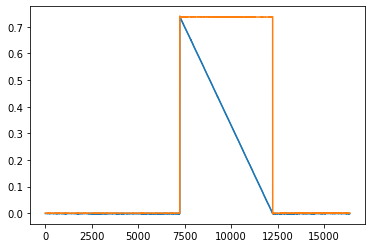

In [31]:
plt.plot(channel1)
plt.plot(channel2)

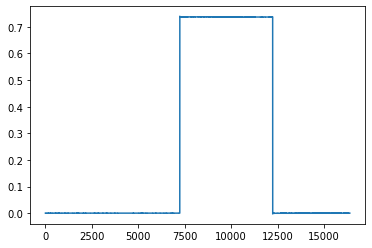

In [30]:
plt.plot(channel2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import os


# Create date of the run folder, if it does not exist
today = datetime.now().strftime('%Y-%m-%d')
if not os.path.exists(r"C:\Users\jitheshs\Data\Cross correlation\\" + today):
    os.mkdir(r"C:\Users\jitheshs\Data\Cross correlation\\" + today)

# Find the number of runs existing in the save folder
dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
idx = 1 + len(os.listdir(dirName))
#Find the path of the new Run folder to be created
newDir = 'Data\Cross correlation\%s\Run %d' % (today,idx)
os.mkdir(newDir)
print("Directory " , newDir ,  " Created ") 


scope_time = 13
repeats = 1
data, datafft, corr_fft = run_example('dev2521', scope_time = scope_time, repeats=repeats)

# Frequency axis values
clockbase = 1.8e9
totalsamples = datafft['/dev2521/scopes/0/wave'][0][0]['totalsamples']
scope_rate = clockbase/2**scope_time
f = np.linspace(0, scope_rate/2, totalsamples)


#Saves file to the directory
np.savetxt(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\f.dat' % (today,idx), f)

np.save(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\data.dat' % (today,idx), data) 

np.save(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\datafft.dat' % (today,idx), datafft) 

np.save(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\corr_fft.dat' % (today,idx), corr_fft) 

In [38]:
data = data_time

Text(0, 0.5, 'Signal amplitude /V')

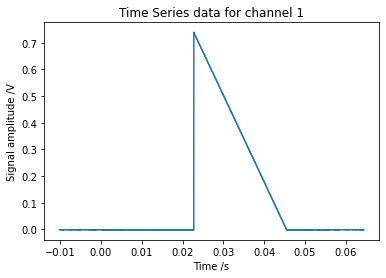

In [41]:
###############################################################
############## Time Domain variable calculations ##############
###############################################################

clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)
wave1 = data[wave_nodepath_master][0][0]['wave'][0]

###############################################################
#################### Time Domain plotting #####################
###############################################################
plt.plot(t, wave1)
plt.title('Time Series data for channel 1')
plt.xlabel('Time /s')
plt.ylabel('Signal amplitude /V')

# Save it
# Find the number of runs existing in the save folder
#today = datetime.now().strftime('%Y-%m-%d')
#dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
#idx = len(os.listdir(dirName))

#plt.savefig(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\%d Time Series data for channel 1.png' % (today,idx, repeats))

Text(0, 0.5, 'Signal amplitude /V')

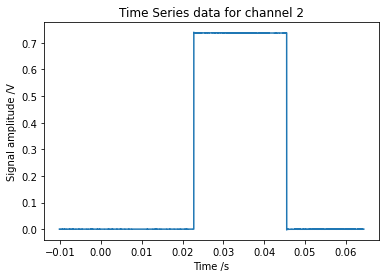

In [43]:
###############################################################
############## Time Domain variable calculations ##############
###############################################################

clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)
wave2 = data[wave_nodepath_master][0][0]['wave'][1]

###############################################################
#################### Time Domain plotting #####################
###############################################################
plt.plot(t, wave2)
plt.title('Time Series data for channel 2')
plt.xlabel('Time /s')
plt.ylabel('Signal amplitude /V')

# Save it
# Find the number of runs existing in the save folder
#today = datetime.now().strftime('%Y-%m-%d')
#dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
#idx = len(os.listdir(dirName))

#plt.savefig(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\%d Time Series data for channel 1.png' % (today,idx, repeats))

In [130]:
%matplotlib qt

# Get time-axis
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)

plt.plot(t, wave1, label = 'Input channel 1',color='red', linewidth=3)
plt.plot(t, wave2, label = 'Input channel 2',color='blue', linewidth=2)

plt.title('Digitized scope data of input channels')
plt.xlabel('Time /s')
plt.ylabel('Signal amplitude /V')

plt.legend(loc='upper left', frameon=True)



In [124]:
0-t[0]

0.010163191666666668

Text(0, 0.5, 'Signal amplitude /V')

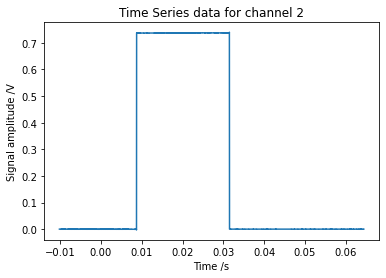

In [45]:
###############################################################
########## Flipped Time Domain variable calculations ##########
###############################################################

clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)
wave = data[wave_nodepath_master][0][0]['wave'][1]
wave = np.flip(wave)

###############################################################
#################### Time Domain plotting #####################
###############################################################
plt.plot(t, wave)
plt.title('Time Series data for channel 2')
plt.xlabel('Time /s')
plt.ylabel('Signal amplitude /V')

# Save it
# Find the number of runs existing in the save folder
#today = datetime.now().strftime('%Y-%m-%d')
#dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
#idx = len(os.listdir(dirName))

#plt.savefig(r'C:\Users\jitheshs\Data\Cross correlation\%s\Run %d\%d Time Series data for channel 1.png' % (today,idx, repeats))

In [ ]:
###############################################################
################ Python Correlation calculation ###############
###############################################################

from scipy import signal 

# Get time-axis
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)

# New time axis values after shifted FFT
shiftedT = np.linspace(min(t), max(t), len(t)*2-1)

wave = data[wave_nodepath_master][0][0]['wave'][0]
wave2 = data[wave_nodepath_master][0][0]['wave'][1]
#wave2 = np.flip(wave2)

txcorr = signal.correlate(wave, wave2, mode = 'full', method='direct')
plt.plot(shiftedT, txcorr/len(txcorr))
plt.title('Cross correlation done through python')
plt.xlabel('Time /s')

In [ ]:
###############################################################
############ Flipped Python Correlation calculation ###########
###############################################################

from scipy import signal 

wave = data[wave_nodepath_master][0][0]['wave'][0]
wave2 = data[wave_nodepath_master][0][0]['wave'][1]
wave2 = np.flip(wave2)

txcorr = signal.correlate(wave, wave2, mode = 'same', method='direct')
plt.plot(t, txcorr/len(txcorr))
plt.title('Cross correlation done through python')
plt.xlabel('Time /s')

In [ ]:
###############################################################
##################### FFT Data calculation ####################
###############################################################

## Get fft from UHFLI for channel 1
fftwave1 = datafft[wave_nodepath_master][0][0]['wave'][0]

## Get fft from UHFLI for channel 2
fftwave2 = datafft[wave_nodepath_master][0][0]['wave'][1]

# Multiply wave 1 with conjugate 
xcorr = np.multiply(fftwave1, np.conj(fftwave2))

# Inverse FFT xcorr
ifftcorr = np.fft.ifft(xcorr)

# Plot
plt.semilogy(ifftcorr)

In [59]:
###############################################################
############### Padded Zeros cross-correlation ################
##################### Python xcorr method #####################
###############################################################

# For wave 2 (square wave)
wave1 = data[wave_nodepath_master][0][0]['wave'][0] # Wave 2
leftZeros = np.where(wave2 == np.amax(wave2)) # Find index of max value of triangle
leftZeros = leftZeros[0][0]-2 # Number of zeros on the left hand side

# The number of zeros to pad
rightZeros = len(wave2)-(45833+leftZeros) # Total length points - (points in triangle ramp + zeros in left-hand side)
zerosToPad = leftZeros - rightZeros # Find the remaining zeros to be added on RHS
paddedwave1 = np.pad(wave1, (0, zerosToPad), 'constant')

# For wave 2 (triangle wave)
wave2 = data[wave_nodepath_master][0][0]['wave'][1] # Wave 2
leftZeros = np.where(wave2 == np.amax(wave2)) # Find index of max value of triangle
leftZeros = leftZeros[0][0]-2 # Number of zeros on the left hand side

# The number of zeros to pad
rightZeros = len(wave2)-(45833+leftZeros) # Total length points - (points in triangle ramp + zeros in left-hand side)
zerosToPad = leftZeros - rightZeros # Find the remaining zeros to be added on RHS
paddedwave2 = np.pad(wave2, (0, zerosToPad), 'constant')

# Calculate new time domain (padded)
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = len(paddedwave1) # the new number of total samples
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)

# Plot 
txcorr = signal.correlate(paddedwave1, paddedwave2, mode = 'same', method='direct')
plt.plot(t, txcorr/len(txcorr))
plt.title('Cross correlation done through python')
plt.xlabel('Time /s')

NameError: name 'signal' is not defined

In [1]:
###############################################################
################# Manual FFT Data calculation #################
###############################################################

# Get time-axis
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)


# Channel 1 time series
wave1 = data[wave_nodepath_master][0][0]['wave'][0]

# Channel 2 time series
wave2 = data[wave_nodepath_master][0][0]['wave'][1]

# FFTs of both channels
fftwave1 = np.fft.fft(wave1, len(wave1)*2-1)
fftwave2 = np.fft.fft(wave2, len(wave2)*2-1)

# Multiply wave 1 with conjugate wave 2
xcorr = np.multiply(fftwave1, np.conj(fftwave2))

# Inverse FFT of xcorr
ifftcorr = np.fft.ifft(xcorr)

# New time axis values after shifted FFT
shiftedT = np.linspace(min(t), max(t), len(t)*2-1)

# Shift inverse FFT
shiftedxcorr = np.fft.fftshift(ifftcorr)

# Plot correlation
#plt.plot(shiftedT, (shiftedxcorr/len(shiftedxcorr)))
#plt.title('Normalized cross correlated signal')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Normalized cross correlated signals')
ax2.plot(shiftedT, shiftedxcorr/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)),color='black', linewidth=3)
ax2.set_title('$f * g$') 
#plt.subplot(1,2,1)
#plt.plot(shiftedT, shiftedxcorr/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)))
ax2.set(xlabel='Time /s', ylabel='Normalized value')
#plt.ylabel('Signal amplitude /V')

## Second conj

# Multiply wave 1 with conjugate wave 2
xcorr = np.multiply(np.conj(fftwave1), fftwave2)

# Inverse FFT of xcorr
ifftcorr = np.fft.ifft(xcorr)

# New time axis values after shifted FFT
shiftedT = np.linspace(min(t), max(t), len(t)*2-1)

# Shift inverse FFT
shiftedxcorr2 = np.fft.fftshift(ifftcorr)

# Plot correlation
#plt.plot(shiftedT, (shiftedxcorr/len(shiftedxcorr)))
#plt.title('Normalized cross correlated signal')

#plt.subplot(1,2,2)
ax1.plot(shiftedT, shiftedxcorr2/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)),color='black', linewidth=3)
ax1.set_title('$g * f$') 
ax1.set(xlabel='Time /s', ylabel='Normalized value')

NameError: name 'data' is not defined

In [129]:
plt.plot(shiftedT, shiftedxcorr/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)),color='red', linewidth=3)
plt.plot(shiftedT, shiftedxcorr2/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)),color='blue', linewidth=3)


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [76]:
1358/0.74

1835.1351351351352

In [2]:
data

NameError: name 'data' is not defined

In [ ]:
plt.plot(shiftedT)

In [1]:
%matplotlib qt

# Get time-axis
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)

plt.plot(t, wave1, label = 'Input channel 1')
plt.plot(t, wave2, label = 'Input channel 2')

plt.title('Digitized scope data of input channels')
plt.xlabel('Time /s')
plt.ylabel('Signal amplitude /V')

plt.legend(loc='upper left', frameon=True)

NameError: name 'data' is not defined

In [64]:
###############################################################
######### Manual FFT Data calculation circular shift ##########
###############################################################

# Get time-axis
clockbase = 1.8e9
wave_nodepath_master='/dev2521/scopes/0/wave'
totalsamples = data[wave_nodepath_master][0][0]['totalsamples']*2
dt = data[wave_nodepath_master][0][0]['dt']
timestamp = data[wave_nodepath_master][0][0]['timestamp']
triggertimestamp = data[wave_nodepath_master][0][0]['triggertimestamp']
t = np.arange(-totalsamples, 0)*dt + (timestamp - triggertimestamp)/float(clockbase)

# Channel 1 time series
wave1 = data[wave_nodepath_master][0][0]['wave'][0]

# Channel 2 time series
wave2 = data[wave_nodepath_master][0][0]['wave'][1]

# FFTs of both channels
fftwave1 = np.fft.fft(wave1, len(wave1)+len(wave2)-1)
fftwave2 = np.fft.fft(wave2, len(wave1)+len(wave2)-1)

# Multiply wave 1 with conjugate wave 2
xcorr = np.multiply(fftwave1, np.conj(fftwave2))

# Inverse FFT of xcorr
ifftcorr = np.fft.ifft(xcorr)

length = len(ifftcorr)
# Shift time domain by half
ifftcorr = np.roll(ifftcorr, int(length/2))
# Plot correlation
plt.plot(t[:32767], ifftcorr/len(ifftcorr))

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [61]:
len(t)

60297

In [ ]:
len(wave1)

In [ ]:
len(ifftcorr)

In [ ]:
###############################################################
################# Inverse FFT Data observation ################
###############################################################

ifftwave1 = np.fft.ifft(fftwave1)
ifftwave2 = np.fft.ifft(fftwave2)
plt.plot(t, ifftwave1)
plt.plot(t, ifftwave2)

In [ ]:
###############################################################
############### corr_fft: the actual calculation ##############
###############################################################

ifftcorr_fft= np.fft.ifft(corr_fft)

plt.plot(t, ifftcorr_fft/len(ifftcorr_fft))

In [70]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-0.2, 0.5, 500, endpoint=False)
t2 = np.linspace(-0.2, 0.5, 250, endpoint=False)
t3 = np.linspace(-0.4, 1.0, 999)
square = (signal.square(2 * np.pi * t - np.pi/2 , duty=0.2) + 1)/3
triangle = np.zeros(500)
triangle[250:500] = (signal.sawtooth(2 * np.pi * t2 - np.pi, 0 ) + 1)/2

txcorr = signal.correlate(square, triangle, mode = 'full', method='direct')
txcorr2 = np.fft.ifft(np.fft.fft(square, 999)*np.conj(np.fft.fft(triangle, 999)))

plt.figure(0)
plt.plot(t, square)
plt.plot(t, triangle)
plt.figure(1)
plt.plot(t3, txcorr)
plt.plot(t3, txcorr2)
plt.figure(2)
plt.plot(t3, np.fft.fftshift(txcorr2), '.')
plt.plot(t3, txcorr)

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [72]:
len(t)

500

In [ ]:
len(txcorr)

In [ ]:
len(square)